In [1]:
import os
import cv2
import csv
import sys
import copy
from tqdm import tqdm
from typing import Union, List, Dict, Any, cast
import random
import librosa
import librosa.display
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd 
import skimage.io
from skimage.transform import resize
import albumentations as albu
from albumentations import pytorch as AT
from PIL import Image
from functools import partial

import pretrainedmodels
from resnest.torch import resnest50

sys.path.append('../')

from src.utils import patch_first_conv
from src.pann import *

import timm
from timm.models.efficientnet import tf_efficientnet_b0_ns, mobilenetv2_100, mobilenetv2_110d, mobilenetv2_140, tf_efficientnet_lite4
from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation


import warnings
warnings.filterwarnings('ignore')



train_folder_path = "../data/train/"
train_np_folder_path = "../data/train_np/"
test_folder_path = "../data/test/"
sample_submission = "../data/sample_submission.csv"
train_tp_path = "../data/train_tp.csv"
train_fp_path = "../data/train_fp.csv"
train_tp_folds = pd.read_csv("../data/train_tp_folds_v3.csv")
train_fp_folds = pd.read_csv("train_fp_folds.csv").drop("Unnamed: 0", 1)


class Config:
    SEED = 17
    NUM_BIRDS = 24
    BATCH_SIZE = 16
    NUM_WORKERS = 4
    FOLD = 4
    TEST_FOLD = 5
    EPOCHS = 50
    
    #optimizer params
    LR = 0.01
    LR_ADAM = 1e-3
    WEIGHT_DECAY = 0.0001
    MOMENTUM = 0.9
    T_MAX = 8
    
    #scheduler params
    FACTOR = 0.8
    PATIENCE = 4

    SR = 48000
    LENGTH_1  = 10* SR
    LENGTH_2 = 5 * SR
    #TODO: MAKE AUGS CONF
    
encoder_params = {
    "efficientnet_b0": {
        #"features": 1280,
        "features": 1792,
        "init_op": partial(mobilenetv2_140, pretrained=True, drop_path_rate=0.2)
        }
    }
    
model_param = {
        'encoder' : 'efficientnet_b0',
        'sample_rate': 48000,
        'window_size' : 2048, #* 2, # 512 * 2
        'hop_size' : 512, #345 * 2, # 320
        'mel_bins' : 224, # 60
        'fmin' : 50,
        'fmax' : 15000,
        'classes_num' : 24
    }


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(Config.SEED)

class AudioSEDModel(nn.Module):
    def __init__(self, encoder, sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 30  # Downsampled ratio
        self.mixup_coff = Mixup(1.)

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(n_fft=window_size, hop_length=hop_size, 
            win_length=window_size, window=window, center=center, pad_mode=pad_mode, 
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=window_size, 
            n_mels=mel_bins, fmin=fmin, fmax=fmax, ref=ref, amin=amin, top_db=top_db, 
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
            freq_drop_width=8, freq_stripes_num=2)
        
        # Model Encoder
        self.encoder = encoder_params[encoder]["init_op"]()
        self.fc1 = nn.Linear(encoder_params[encoder]["features"], 1024, bias=True)
        self.att_block = AttBlock(1024, classes_num, activation="sigmoid")
        self.bn0 = nn.BatchNorm2d(mel_bins)
        self.init_weight()
    
    def init_weight(self):
        init_layer(self.fc1)
        init_bn(self.bn0)
    
    def forward(self, input, mixup_lambda=None):
        """Input : (batch_size, data_length)"""

        x = self.spectrogram_extractor(input)
        # batch_size x 1 x time_steps x freq_bins
        x = self.logmel_extractor(x)
        # batch_size x 1 x time_steps x mel_bins

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        #print(x.shape)

        if self.training and False:
            x = self.spec_augmenter(x)
        
        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        
        # Output shape (batch size, channels, time, frequency)
        x = x.expand(x.shape[0], 3, x.shape[2], x.shape[3])
        #print(x.shape)
        x = self.encoder.forward_features(x)
        #print(x.shape)
        x = torch.mean(x, dim=3)
        #print(x.shape)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2
        #print(x.shape)

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        #print(x.shape)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)
        
        framewise_logit = interpolate(segmentwise_logit, self.interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit,
            "clipwise_output": clipwise_output
        }


        return output_dict
    
def crop_or_pad(y, is_train=True):
    length = Config.LENGTH_2
    if len(y) < length:
        
        pad_width = length - len(y)
        pad_sub = start = np.random.randint(0, pad_width)
        
        y = np.pad(y, (pad_sub, pad_width-pad_sub), "minimum")
    elif len(y) > length:
        start = np.random.randint(len(y) - length)
        
        y = y[start:start + length]

    y = y.astype(np.float32, copy=False)
    #print(y.shape)

    return y

/home/user/.local/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def load_test_file(f, win_size = 5): 
    wav, sr = librosa.load('../data/test/' + f, sr=None )

    # Split for enough segments to not miss anything
    window = win_size * Config.SR
    stride = 5 * Config.SR
    full_length = 60 * Config.SR
    
    mel_array = []
    for i in range(0, full_length, window):
    #for i in range(0, full_length + stride - window, stride):
        
        wav_slice = wav[i:i+window]
        #new_sample_rate = 24000
        #wav_slice = librosa.resample(slice, Config.SR, new_sample_rate)
        #wav_slice = np.expand_dims(wav_slice, axis=0).astype(np.float32) 
        wav_slice = wav_slice.astype(np.float32) * 10.
        mel_array.append(wav_slice)
    
    return np.array(mel_array)

model = AudioSEDModel(**model_param)
#model.load_state_dict(torch.load(f"best_model_{Config.FOLD}.pt"))
model.load_state_dict(torch.load(f"best_model_only_train.pt"))

use_cuda = True

if torch.cuda.is_available() and use_cuda:
    model.cuda()

model.eval()
# Prediction loop
TTA = [5,10,20,30,60]

for length in TTA:
    print('Starting prediction loop')
    with open(f'submission_{Config.FOLD}{length}.csv', 'w', newline='') as csvfile:
        submission_writer = csv.writer(csvfile, delimiter=',')
        submission_writer.writerow(['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
                                   's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','s22','s23'])

        test_files = os.listdir('../data/test/')
        print(len(test_files))

        # Every test file is split on several chunks and prediction is made for each chunk
        for i in range(0, len(test_files)):
            data = load_test_file(test_files[i], win_size = length)
            data = torch.tensor(data)
            data = data.float()
            if torch.cuda.is_available() and use_cuda:
                data = data.cuda()

            output = model(data)

            # Taking max prediction from all slices per bird species
            # Usually you want Sigmoid layer here to convert output to probabilities
            # In this competition only relative ranking matters, and not the exact value of prediction, so we can use it directly

            framewise_output = output["framewise_output"]
            output, _ = framewise_output.max(dim=1) 
            maxed_output = torch.max(output, dim=0)[0]
            #maxed_output = torch.max(output["clipwise_output"], dim=0)[0]
            maxed_output = maxed_output.cpu().detach()

            file_id = str.split(test_files[i], '.')[0]
            write_array = [file_id]

            for out in maxed_output:
                write_array.append(out.item())

            submission_writer.writerow(write_array)

            if i % 100 == 0 and i > 0:
                print('Predicted for ' + str(i) + ' of ' + str(len(test_files) + 1) + ' files')

    print('Submission generated')

Starting prediction loop
1992
Predicted for 100 of 1993 files
Predicted for 200 of 1993 files
Predicted for 300 of 1993 files
Predicted for 400 of 1993 files
Predicted for 500 of 1993 files
Predicted for 600 of 1993 files
Predicted for 700 of 1993 files
Predicted for 800 of 1993 files
Predicted for 900 of 1993 files
Predicted for 1000 of 1993 files
Predicted for 1100 of 1993 files
Predicted for 1200 of 1993 files
Predicted for 1300 of 1993 files
Predicted for 1400 of 1993 files
Predicted for 1500 of 1993 files
Predicted for 1600 of 1993 files
Predicted for 1700 of 1993 files
Predicted for 1800 of 1993 files
Predicted for 1900 of 1993 files
Submission generated
Starting prediction loop
1992
Predicted for 100 of 1993 files
Predicted for 200 of 1993 files
Predicted for 300 of 1993 files
Predicted for 400 of 1993 files
Predicted for 500 of 1993 files
Predicted for 600 of 1993 files
Predicted for 700 of 1993 files
Predicted for 800 of 1993 files
Predicted for 900 of 1993 files
Predicted for

In [3]:
sub1 = pd.read_csv(f"submission_{Config.FOLD}5.csv")
sub2 = pd.read_csv(f"submission_{Config.FOLD}10.csv")
sub3 = pd.read_csv(f"submission_{Config.FOLD}20.csv")
sub4 = pd.read_csv(f"submission_{Config.FOLD}30.csv")
sub5 = pd.read_csv(f"submission_{Config.FOLD}60.csv")


BLEND=sub1.copy() 
BLEND.iloc[:,1:] = sub1.iloc[:,1:] +sub2.iloc[:,1:] +sub3.iloc[:,1:] +sub4.iloc[:,1:] +sub5.iloc[:,1:] 
BLEND.to_csv(f"submission_{Config.FOLD}_TTA.csv", index=False)

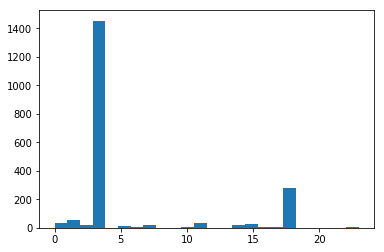

In [6]:
df = pd.read_csv(f"submission_4_TTA_calibrated.csv")
#df =BLEND
a = df.iloc[:, 1:].to_numpy()
plt.hist(a.argmax(axis=1), bins=24)
plt.show()

In [5]:
df = pd.read_csv("submission_4_TTA.csv")
coeffiicients = np.array([0.25, 0.289, 0.238, 0.508, 0.229, 0.221, 0.212, 
                          0.285, 0.228, 0.215, 0.218, 0.263, 0.297, 0.216, 
                          0.247, 0.279, 0.220, 0.218, 0.360, 0.212, 0.215, 
                          0.221,0.219, 0.240])
df.iloc[:, 1] = df.iloc[:, 1] * coeffiicients[0] 
df.iloc[:, 2] = df.iloc[:, 2] * coeffiicients[1] * 1.5
df.iloc[:, 3] = df.iloc[:, 3] * coeffiicients[2] 
df.iloc[:, 4] = df.iloc[:, 4] * coeffiicients[3]
df.iloc[:, 5] = df.iloc[:, 5] * coeffiicients[4]
df.iloc[:, 6] = df.iloc[:, 6] * coeffiicients[5]
df.iloc[:, 7] = df.iloc[:, 7] * coeffiicients[6]
df.iloc[:, 8] = df.iloc[:, 8] * coeffiicients[7] 
df.iloc[:, 9] = df.iloc[:, 9] * coeffiicients[8]
df.iloc[:, 10] = df.iloc[:, 10] * coeffiicients[9]
df.iloc[:, 11] = df.iloc[:, 11] * coeffiicients[10]
df.iloc[:, 12] = df.iloc[:, 12] * coeffiicients[11]
df.iloc[:, 13] = df.iloc[:, 13] * coeffiicients[12]
df.iloc[:, 14] = df.iloc[:, 14] * coeffiicients[13]
df.iloc[:, 15] = df.iloc[:, 15] * coeffiicients[14]
df.iloc[:, 16] = df.iloc[:, 16] * coeffiicients[15]
df.iloc[:, 17] = df.iloc[:, 17] * coeffiicients[16]
df.iloc[:, 18] = df.iloc[:, 18] * coeffiicients[17]
df.iloc[:, 19] = df.iloc[:, 19] * coeffiicients[18] * 2.5
df.iloc[:, 20] = df.iloc[:, 20] * coeffiicients[19]
df.iloc[:, 21] = df.iloc[:, 21] * coeffiicients[20]
df.iloc[:, 22] = df.iloc[:, 22] * coeffiicients[21]
df.iloc[:, 23] = df.iloc[:, 23] * coeffiicients[22]
df.iloc[:, 24] = df.iloc[:, 24] * coeffiicients[23]
#df.s20 = -10
#df.s22 = -10
df.to_csv("submission_4_TTA_calibrated.csv", index=False)

In [22]:
sub1 = pd.read_csv(f"submission_mobnet_framewise_0_TTA.csv")
sub2 = pd.read_csv(f"submission_mobnet_framewise_1_TTA.csv")
sub3 = pd.read_csv(f"submission_mobnet_framewise_2_TTA.csv")
sub4 = pd.read_csv(f"submission_mobnet_framewise_3_TTA.csv")
sub5 = pd.read_csv(f"submission_mobnet_framewise_4_TTA.csv")
#sub6 = pd.read_csv(f"submission_sed_framewise_5_TTA.csv")


BLEND=sub1.copy() 
BLEND.iloc[:,1:] = sub1.iloc[:,1:] +sub2.iloc[:,1:] +sub3.iloc[:,1:] +sub4.iloc[:,1:] +sub5.iloc[:,1:] #+sub6.iloc[:,1:] 
BLEND.to_csv(f"submission_sed_mobnet_framewise_TTA_ens.csv", index=False)